In [1]:
import numpy
import pygad
import warnings
warnings.filterwarnings("ignore")
import pygad.nn
import pygad.gann
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

labelencoder = LabelEncoder()


In [2]:
data = pd.read_csv('databases/wine.data', names = ['class', 'alcohol', 'malic acid', 'ash', 'alcalinity of ash', 'magnesium', 'total phenols', 'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'diluted', 'proline'])

target = labelencoder.fit_transform(data['class'].values)
data_drop = data.drop('class',axis=1)
data = data_drop.values

sc = StandardScaler()
data = sc.fit_transform(data)

In [3]:
def fitness_func(solution, sol_idx):
    global GANN_instance, data_inputs, data_outputs

    predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[sol_idx],
                                   data_inputs=data_inputs)
    correct_predictions = numpy.where(predictions == data_outputs)[0].size
    solution_fitness = (correct_predictions/data_outputs.size)*100

    return solution_fitness

def callback_generation(ga_instance):
    global GANN_instance, last_fitness

    population_matrices = pygad.gann.population_as_matrices(population_networks=GANN_instance.population_networks,
                                                            population_vectors=ga_instance.population)

    GANN_instance.update_population_trained_weights(population_trained_weights=population_matrices)

    last_fitness = ga_instance.best_solution()[1].copy()

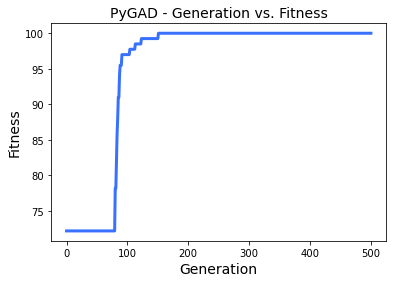

Parameters of the best solution : [-0.06965828  0.0013668  -0.05435557 ...  0.05538884  0.05774132
  0.05252772]
Fitness value of the best solution = 100.0
Index of the best solution : 0
Best fitness value reached after 151 generations.
Predictions of the trained network : [2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 2]
Number of correct classifications : 42.
Number of wrong classifications : 3.
Classification accuracy : 93.33333333333333.


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target)

data_inputs = x_train
data_outputs = y_train

last_fitness = 0
# The length of the input vector for each sample (i.e. number of neurons in the input layer).
num_inputs = data_inputs.shape[1]
# The number of neurons in the output layer (i.e. number of classes).
num_classes = 3

num_solutions = 50 # A solution or a network can be used interchangeably.
GANN_instance = pygad.gann.GANN(num_solutions=num_solutions,
                                num_neurons_input=num_inputs,
                                num_neurons_hidden_layers=[100, 30],
                                num_neurons_output=num_classes,
                                hidden_activations=["relu", "relu"],
                                output_activation="softmax")


population_vectors = pygad.gann.population_as_vectors(population_networks=GANN_instance.population_networks)

# Initial population
initial_population = population_vectors.copy()

num_parents_mating = 4 # Number of solutions to be selected as parents in the mating pool.

num_generations = 500 # Number of generations.

mutation_percent_genes = 10 # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.

parent_selection_type = "sss" # Type of parent selection.

crossover_type = "scattered" # Type of the crossover operator.

mutation_type = "swap" # Type of the mutation operator.

keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       mutation_percent_genes=mutation_percent_genes,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

ga_instance.run()

    # After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

# Predicting the outputs of the data using the best solution.
predictions = pygad.nn.predict(last_layer=GANN_instance.population_networks[solution_idx],
                                   data_inputs=x_test)
print("Predictions of the trained network : {predictions}".format(predictions=predictions))

    # Calculating some statistics
num_wrong = numpy.where(predictions != y_test)[0]
num_correct = y_test.size - num_wrong.size
accuracy = 100 * (num_correct/y_test.size)
print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))